In [11]:
using FEM, Potential, AlphaBeta, PyPlot, Printf, PhotonOperator, JLD, LinearAlgebra, Diffusity, Dierckx

### Part 1: Get collocation points and integration kernel for whole domain

In [2]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration
Nv = 72    # Number of eigenvectors

# Define Physical Domain
xratio = 64. # unit: angstrom
xavg = 0.   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V(x)$ and $p_{\rm eq}(x)$

In [3]:
sigma_kref = 8.
kref = get_k_by_sigma(sigma_kref)
Vref = harmonic_well_k_mean(xref, kref, xavg)
rho_eq = get_rhoeq(Vref, w0)
p_eq = rho_eq .* rho_eq;

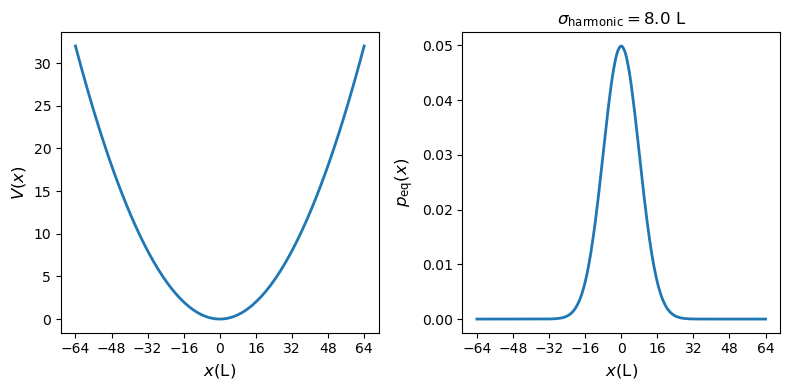

In [4]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))

ax = axes[1]
ax.plot(xref, Vref, linewidth=2)
ax.set_xlabel("\$x\$(L)", fontsize=12)
ax.set_ylabel("\$V(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)
#ax.set_ylim(0, 10)

ax = axes[2]
ax.plot(xref, p_eq, linewidth=2)
ax.set_xlabel("\$x\$(L)", fontsize=12)
ax.set_ylabel("\$p_{\\rm eq}(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)
ax.set_title(@sprintf "\$\\sigma_{\\rm harmonic} = %.1f\$ L" sigma_kref)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/harmonic_well_r.svg")
plt.show()

### Part 3: Set parameters about simulations

In [4]:
# physical parameters
save_freq = 1e-2 # unit: s, Save trajectory per 1e-2 s
total_times = 100 # unit: s, totol simulate 100 s
dt = 2e-5 # unit: s  # Integration Times 1ps
D = 500; # Diffusion coefficient, unit: s-1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 500 timesteps. There will be 10000 data points.


In [5]:
# Read simulated trajectory from jld file
f_in = "/home/yizaochen/codes/julia/md_pisl/trajectory/harmonic_well_r_0.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
k_ref = load(f_in, "k_ref")
D = load(f_in, "D");

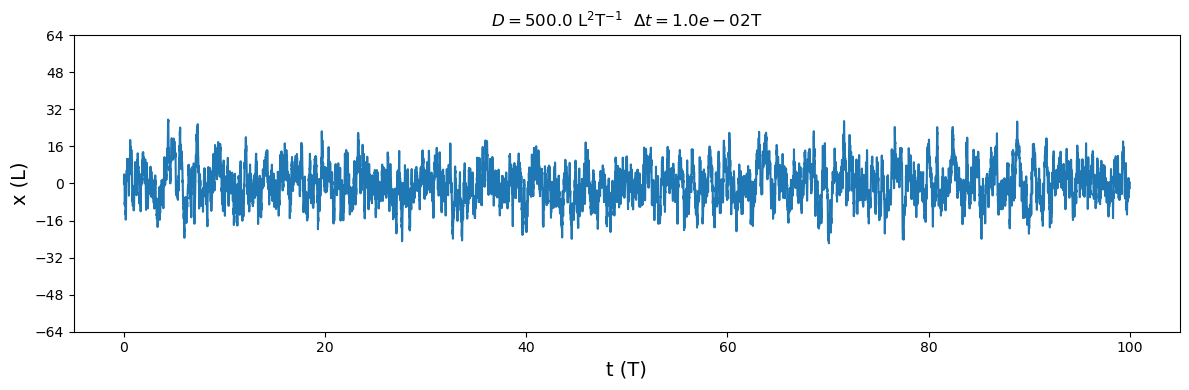

In [6]:
lbfz = 14
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))

ax.plot(t_record, y_record)
ax.set_ylabel("x (L)", fontsize=lbfz)
ax.set_xlabel("t (T)", fontsize=lbfz)
ax.set_title(@sprintf "\$ D=%.1f\$ L\$^{2}\$T\$^{-1}\$  \$\\Delta t=%.1e\$T " D save_freq)
ax.set_yticks(-64:16:64)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/reduced_traj.svg")
plt.show()

### Part 4: FEM to get eigenvector and eigenvalues when $D=1$

In [6]:
D_unity = 1e0
eigenvalues_prime, eigenvect_mat_prime, rho_eq_by_fem_prime = fem_solve_eigen_by_pref(Nh, Np, xratio, xavg, p_eq, D_unity, Nv)
weight_Qx_prime = get_weight_Qx(N, Nv, w0, eigenvect_mat_prime);

### Part 5: Set Photon $\sigma$

In [7]:
σ_delta = 0.5
k_delta = get_k_by_sigma(σ_delta);

### Part 6: Scan D

In [15]:
D_array = [value for value=350.:10.:750.];

In [16]:
l_array = Diffusity.scan_l_by_vary_D(Nv, tau, w0, p_eq, N, eigenvect_mat_prime, y_record, xref, e_norm, interpo_xs, 
    Np, k_delta, D_array, eigenvalues_prime, save_freq);

In [ ]:
Q_array = Diffusity.scan_Q_by_vary_D(Nv, tau, w0, p_eq, N, eigenvect_mat_prime, y_record, xref, e_norm, interpo_xs, 
    Np, k_delta, D_array, eigenvalues_prime, save_freq);

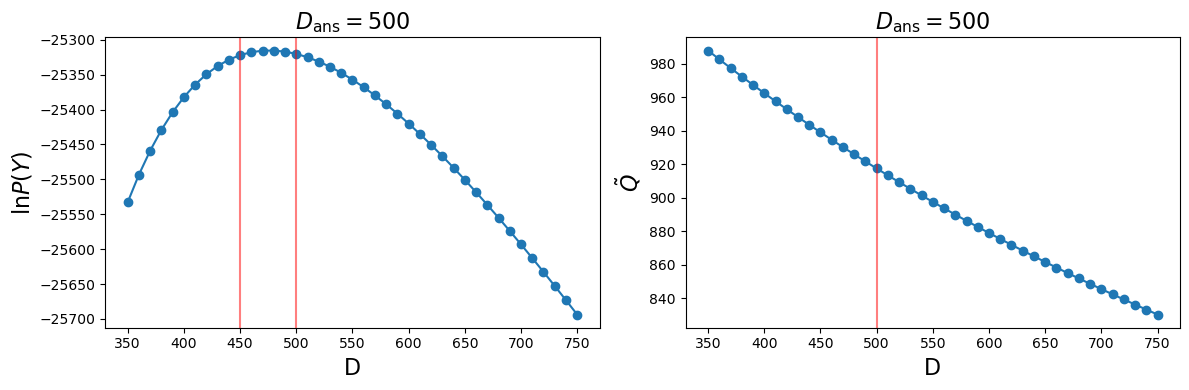

In [32]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))

ax = axes[1]
ax.plot(D_array, l_array, "-o")
ax.axvline(500, color="red", alpha=0.5)
ax.axvline(450, color="red", alpha=0.5)
ax.set_xlabel("D", fontsize=16)
ax.set_ylabel("\$\\ln{P(Y)}\$", fontsize=16)
ax.set_title("\$D_{\\mathrm{ans}}=500\$", fontsize=16)

ax = axes[2]
ax.plot(D_array, Q_array, "-o")
ax.axvline(500, color="red", alpha=0.5)
ax.set_xlabel("D", fontsize=16)
ax.set_ylabel("\$\\tilde{Q}\$", fontsize=16)
ax.set_title("\$D_{\\mathrm{ans}}=500\$", fontsize=16)

plt.tight_layout()
#plt.savefig("/home/ytcdata/em_theory/Pictures/ch2/lnpy_Q.pdf")
plt.show()

### Part 7-1: $Q(\theta) = \sum_{t=1}^{N_p} \frac{\left<\hat{\alpha}^k_{t-1} | e^{-\textbf{H}\Delta t_{\tau}} \textbf{y}_{\tau} | \hat{\beta}_{t}\right> }{c_t}$

In [13]:
D_value = 500.
alpha_mat, beta_mat, Anorm_vec = Diffusity.get_alpha_beta_Anorm(Nv, tau, w0, p_eq, N, eigenvect_mat_prime, y_record, xref, e_norm, interpo_xs, 
    Np, k_delta, D_value, eigenvalues_prime, save_freq)
big_photon_mat = Diffusity.get_big_photon_mat(N, Nv, w0, k_delta, xref, eigenvect_mat_prime)
idx_array = [find_nearest_point(y_record[time_idx], xref, e_norm, interpo_xs, Np) for time_idx=1:tau]
D_guess = D_value * ones(Nv)
expLQDT = exp.(-(D_guess .* eigenvalues_prime) .* save_freq);

In [14]:
time_idx = 100
dot(alpha_mat[:,time_idx], beta_mat[:,time_idx])

1.000000000000549

### Part 7-2: $\left<\hat{\alpha}^k_{t-1} | e^{-\textbf{H}\Delta t_{\tau}} \textbf{y}_{\tau} | \hat{\beta}_{t}\right>$

In [15]:
time_idx = 100
alpha_hat_t_prev = alpha_mat[:,time_idx-1]
beta_hat_t = beta_mat[:,time_idx];

In [16]:
alpha_hat_t_prev_edt = expLQDT .* alpha_hat_t_prev
psi_photon_psi = big_photon_mat[:,:,idx_array[time_idx]]
alpha_hat_t_prev_edt_y = alpha_hat_t_prev_edt' * psi_photon_psi;

In [17]:
dot(alpha_hat_t_prev_edt_y, beta_hat_t)

0.12451745013569211

In [18]:
alpha_hat_t_prev_edt_y[1]

0.12451745013562371

In [19]:
Anorm_vec[time_idx]

0.12451745013562375

In [20]:
sum_value = 0.
for eigv_idx=1:Nv
    sum_value += alpha_hat_t_prev_edt_y[eigv_idx] * beta_hat_t[eigv_idx]
end
sum_value 

0.12451745013569211

### Part 8: $\ln{P(Y)} = \sum_{t=1}^{N_p} \ln{\sum_{i=1}^{Nv}  e^{-D_i \lambda'_i \Delta t} \left< \hat{\alpha}_{t-1} | \psi_i \right> \left< \psi_i | \textbf{y}_t | \hat{\beta}_{t} \right>}$

In [13]:
D_old = 500.
D_array = [value for value=350.:10.:750.];

In [14]:
l_array_fix_alpha_beta = Diffusity.calculate_l_by_decomp_vary_D(Nv, tau, w0, p_eq, N, eigenvect_mat_prime, y_record, xref, e_norm, interpo_xs, 
    Np, k_delta, D_old, D_array, eigenvalues_prime, save_freq);

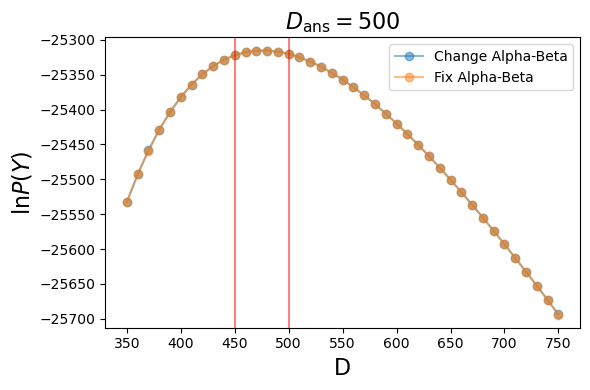

In [22]:
fig, ax = plt.subplots(ncols=1, figsize=(6,4))

ax.plot(D_array, l_array, label="Change Alpha-Beta", alpha=0.5, "-o")
ax.plot(D_array, l_array_fix_alpha_beta, label="Fix Alpha-Beta", alpha=0.5,"-o")
ax.axvline(500, color="red", alpha=0.5)
ax.axvline(450, color="red", alpha=0.5)
ax.set_xlabel("D", fontsize=16)
ax.set_ylabel("\$\\ln{P(Y)}\$", fontsize=16)
ax.set_title("\$D_{\\mathrm{ans}}=500\$", fontsize=16)
ax.legend()

plt.tight_layout()
#plt.savefig("/home/ytcdata/em_theory/Pictures/ch2/lnpy_Q.pdf")
plt.show()

### Part 9: Numerical and Analytical $\frac{d \ln{P(Y)}}{dD}$

In [19]:
dldD_array_analytical = Diffusity.calculate_l_derivative_by_decomp_vary_D(Nv, tau, w0, p_eq, N, eigenvect_mat_prime, y_record, xref, e_norm, interpo_xs, 
    Np, k_delta, D_old, D_array, eigenvalues_prime, save_freq);

In [20]:
# Get derivative
l_spl = Spline1D(D_array, l_array_fix_alpha_beta)
dldD_array_numerical = zeros(length(D_array))
for idx = 1:length(D_array)
    dldD_array_numerical[idx] = derivative(l_spl, D_array[idx])
end

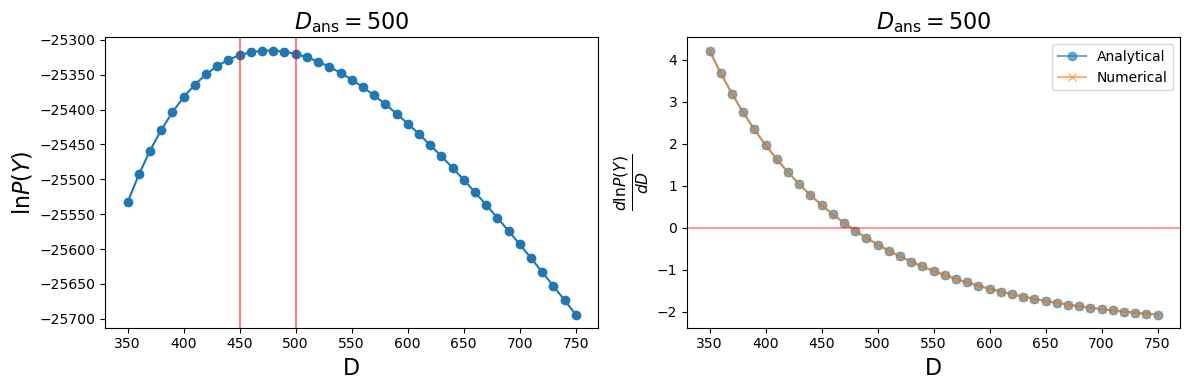

In [24]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))

ax = axes[1]
ax.plot(D_array, l_array_fix_alpha_beta, alpha=1,"-o")
ax.axvline(500, color="red", alpha=0.5)
ax.axvline(450, color="red", alpha=0.5)
ax.set_xlabel("D", fontsize=16)
ax.set_ylabel("\$\\ln{P(Y)}\$", fontsize=16)
ax.set_title("\$D_{\\mathrm{ans}}=500\$", fontsize=16)

ax = axes[2]
ax.plot(D_array, dldD_array_analytical, label="Analytical", alpha=0.6, "-o")
ax.plot(D_array, dldD_array_numerical, label="Numerical", alpha=0.6, "-x")
ax.axhline(0, color="red", alpha=0.4)
ax.set_xlabel("D", fontsize=16)
ax.set_ylabel("\$\\frac{d\\ln{P(Y)}}{dD}\$", fontsize=16)
ax.set_title("\$D_{\\mathrm{ans}}=500\$", fontsize=16)
ax.legend()

plt.tight_layout()
#plt.savefig("/home/ytcdata/em_theory/Pictures/ch2/dldD_analytical_numerical.pdf")
plt.show()

### Part 9: $\sum_{t}c_t$ for different $D$

In [43]:
D_value = 480
D_guess = D_value * ones(Nv)
expLQDT = exp.(-(D_guess .* eigenvalues_prime) .* save_freq);

In [44]:
inner_store = zeros(tau)

psi_photon_psi = big_photon_mat[:,:,idx_array[1]]
y_beta_hat_t = psi_photon_psi *  beta_mat[:,1]
alpha0 = zeros(Nv)
alpha0[1] = 1
inner_store[1] = dot(alpha0, y_beta_hat_t)

for time_idx=2:tau
    psi_photon_psi = big_photon_mat[:,:,idx_array[time_idx]]
    y_beta_hat_t = psi_photon_psi *  beta_mat[:,time_idx]
    alpha_t_prev_edt = expLQDT .* alpha_mat[:,time_idx-1]
    inner_store[time_idx] = dot(alpha_t_prev_edt, y_beta_hat_t)
end
sum(log.(inner_store))

-25315.362194624344

In [ ]:
350: -25532.622274550708
450: -25321.981375169846
480: -25315.362194
500: -25320.196
700: -25593.33524097229

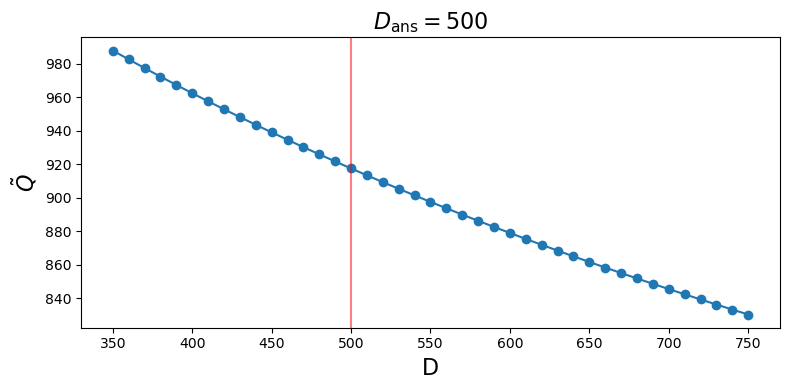

In [24]:
fig, ax = plt.subplots(figsize=(8,4))



plt.tight_layout()
plt.show()

### Part 10: $\left<\hat{\alpha}_{t-1} | e^{-\textbf{H}\Delta t} \textbf{y}_{t} | \hat{\beta}_{t}\right>$ vs $\left<\hat{\alpha}_{t-1} | e^{-\textbf{H}\Delta t} \textbf{y}_{t} | \psi_1\right>$

In [24]:
1:tau

1:10000

In [26]:
Anorm_vec

1×10000 Array{Float64,2}:
 0.049851  0.0563314  0.0658507  0.0584216  …  0.126209  0.12673  0.128045

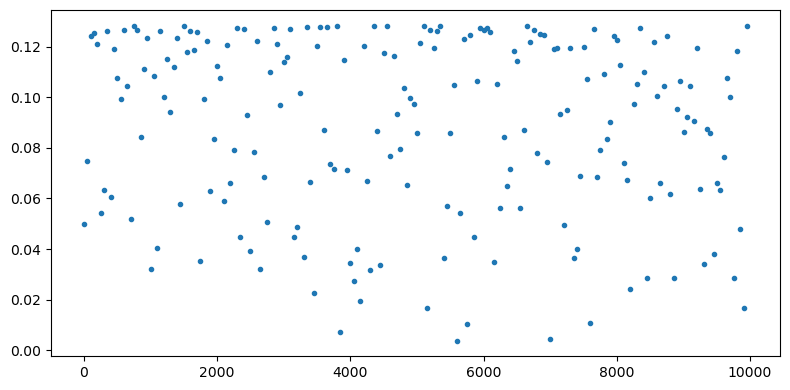

In [31]:
fig, ax = plt.subplots(figsize=(8,4))

xarray = 1:50:tau
ax.plot(xarray, Anorm_vec[1,xarray], ".")
#ax.set_xlabel("t")
#ax.set_ylabel("\$c_t\$")
plt.tight_layout()
plt.show()

In [23]:
data_container = zeros(Nv,tau)

time_idx = 1
psi_photon_psi = big_photon_mat[:,:,idx_array[time_idx]]
y_beta_hat_t = psi_photon_psi *  beta_mat[:,time_idx]
alpha0 = zeros(Nv)
alpha0[1] = 1
data_container[:,1] = alpha0 .* y_beta_hat_t

for time_idx=2:tau
    psi_photon_psi = big_photon_mat[:,:,idx_array[time_idx]]
    y_beta_hat_t = psi_photon_psi *  beta_mat[:,time_idx]
    alpha_t_prev_edt = expLQDT .* alpha_mat[:,time_idx-1]
    data_container[:,time_idx] = alpha_t_prev_edt .* y_beta_hat_t
end
#sum(log.(inner_store))

In [24]:
decompose_result = [sum(data_container[eigv,:]) for eigv=1:Nv]

72-element Array{Float64,1}:
 356.31467912381106
 144.84655061580162
   1.8385448634421524e-5
   1.6079558413747425e-5
  98.94715701949286
  66.18613897374928
  51.90997019263179
  38.11606908897008
  30.947151672186124
  24.02380942866538
  19.255092672748496
  15.320547975947376
  10.842957065908191
   ⋮
  -1.2407030646587412e-5
   4.179733420470852e-6
  -5.428771037353506e-6
   1.1081687576184868e-6
  -1.2143354461495619e-6
   7.740635702119314e-7
  -8.914233847389472e-7
   4.2484153016447106e-7
  -4.849064952622128e-7
   7.290675831880401e-8
  -1.0192183252666291e-7
  -5.432396950762168e-8

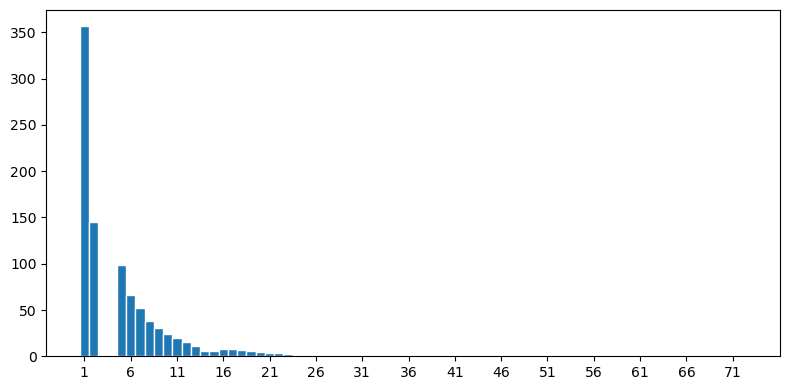

In [53]:
fig, ax = plt.subplots(figsize=(8,4))

ax.bar(1:Nv, decompose_result, 1, edgecolor="white")
ax.set_xticks(1:5:Nv)

plt.tight_layout()
plt.show()

### $\sum_{t}\left<\hat{\alpha}^k_{t-1} | e^{-\textbf{H}\Delta t_{\tau}} \textbf{y}_{\tau} | \hat{\beta}_{t}\right>$

In [54]:
sum(decompose_result)

917.4430028317046

In [8]:
D_old = 500.
D_array = [value for value=350.:25.:500.];

In [9]:
Q_decomp_mat = Diffusity.calculate_decomp_Q_vary_D(Nv, tau, w0, p_eq, N, eigenvect_mat_prime, y_record, xref, e_norm, interpo_xs, 
    Np, k_delta, D_array, eigenvalues_prime, save_freq);

In [29]:
Q_decomp_mat

72×31 Array{Float64,2}:
 356.315        356.315        356.315        …  356.315        356.315
 150.617        150.029        149.444           134.485        133.961
   1.93574e-5     1.9258e-5      1.9159e-5         1.66711e-5     1.65855e-5
   1.69302e-5     1.68431e-5     1.67565e-5        1.45793e-5     1.45044e-5
 106.987        106.155        105.329            85.2978        84.634
  74.4151        73.5481        72.6913       …   52.9747        52.3575
  60.6889        59.748         58.8217           38.5762        37.9781
  46.3376        45.4413        44.5624           26.2991        25.7904
  39.1217        38.2154        37.33             19.8247        19.3654
  31.5811        30.7291        29.9              14.2872        13.9018
  26.3234        25.5131        24.7277       …   10.63          10.3027
  21.7759        21.0236        20.2972            7.85488        7.5835
  15.9852        15.3766        14.7912            5.1864         4.98895
   ⋮                 

In [11]:
Q_array = [sum(Q_decomp_mat[:,idx]) for idx=1:length(D_array)]

7-element Array{Float64,1}:
 987.9281621873226
 974.9011805773142
 962.435034795271
 950.4898373717383
 939.0302417812028
 928.0243049465865
 917.4430028317046

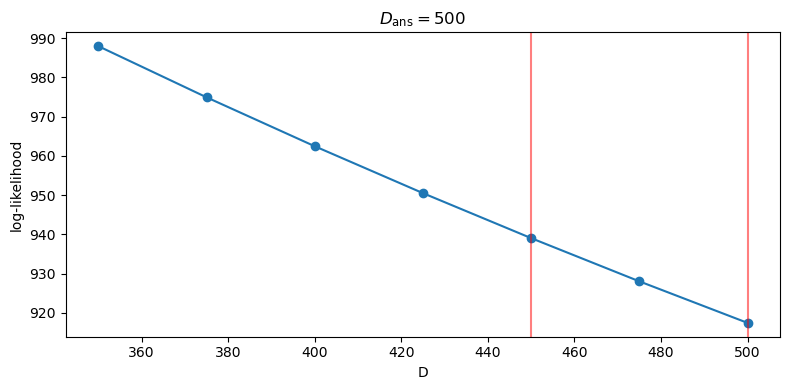

In [12]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(D_array, Q_array, "-o")
ax.axvline(500, color="red", alpha=0.5)
ax.axvline(450, color="red", alpha=0.5)
ax.set_xlabel("D")
ax.set_ylabel("log-likelihood")
ax.set_title("\$D_{\\mathrm{ans}}=500\$")

plt.tight_layout()
plt.show()